In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial import Voronoi
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [ ]:
def happiness(R=1, A=0.5, f=6, N=10, T_steps=500, dt=0.1, k=2):
    
    '''
    R: radius
    A: amplitude
    f: freq
    N: num drones
    T_steps: time steps
    dt: inc in time
    k: gain
    
    '''
    #init
    theta_init = 2 * np.pi * np.arange(N) / N
    r_init = R + A * np.sin(f * theta_init)
    x_init = r_init * np.cos(theta_init)
    y_init = r_init * np.sin(theta_init)


    p = np.stack([x_init, y_init], axis=1)

    drone_positions = [p.copy()]
    targets = []
    
    time = 0

    #changes
    for step in range(T_steps - 1):
        time += dt
        
        theta_target = np.arctan2(np.sin(time + theta_init), np.cos(time + theta_init))
        r_target = R + A * np.sin(f * theta_target)
        x_target = r_target * np.cos(theta_target)
        y_target = r_target * np.sin(theta_target)
        p_target = np.stack([x_target, y_target], axis=1)
        targets.append(p_target.copy())

        velocity = p_target - p
        p = p + k * velocity * dt
        
        drone_positions.append(p.copy())
        
    return np.array(drone_positions), np.array(targets)

In [6]:
def surprise(r_min=0.2, r_max=1, N=10, T_steps=500, dt=0.05, k=1):

    #init
    theta_init = 2 * np.pi * np.arange(N) / N
    
    r0 = r_min
    x_init = r0 * np.cos(theta_init)
    y_init = r0 * np.sin(theta_init)
    p = np.stack([x_init, y_init], axis=1)
    
    drone_positions = [p.copy()]
    targets = []
    
    time = 0

    for step in range(T_steps - 1):
        time += dt

        theta_t = np.arctan2(np.sin(time + theta_init), np.cos(time + theta_init))
        
        r_t = np.mod(time, r_max - r_min) + r_min
        x_target = r_t * np.cos(theta_t)
        y_target = r_t * np.sin(theta_t)
        p_target = np.stack([x_target, y_target], axis=1)
        targets.append(p_target.copy())

        velocity = p_target - p
        p = p + k * velocity * dt
        
        drone_positions.append(p.copy())

    return np.array(drone_positions), np.array(targets)

In [ ]:
def sadness(R=0.5, N=10, T_steps=500, dt=0.05, k=1):
    """
    
    """
    # init
    theta_init = 2 * np.pi * np.arange(N) / N

    x_init = R * np.cos(theta_init)
    y_init = R * np.sin(theta_init)
    p = np.stack([x_init, y_init], axis=1)

    drone_positions = [p.copy()]
    targets = []

    time = 0
    for step in range(T_steps - 1):
        time += dt

        theta_t = np.arctan2(np.sin(time + theta_init), np.cos(time + theta_init))

        x_target = R * np.cos(theta_t)
        y_target = R * np.sin(theta_t)
        p_target = np.stack([x_target, y_target], axis=1)
        targets.append(p_target.copy())

        velocity = p_target - p
        p = p + k * velocity * dt

        drone_positions.append(p.copy())

    return np.array(drone_positions), np.array(targets)

In [ ]:
# def anger(N=10, T_steps=500, dt=0.05, k=1.0, R=0.2):


#     def coverageController(p_i, c_i, k=1):
#         return p_i + k * (c_i - p_i)
    
#     def density():
#         return
    

#     voronoi = Voronoi()

#     return np.array(drone_positions), np.array(targets)

Saving animation as GIF... This may take a moment.


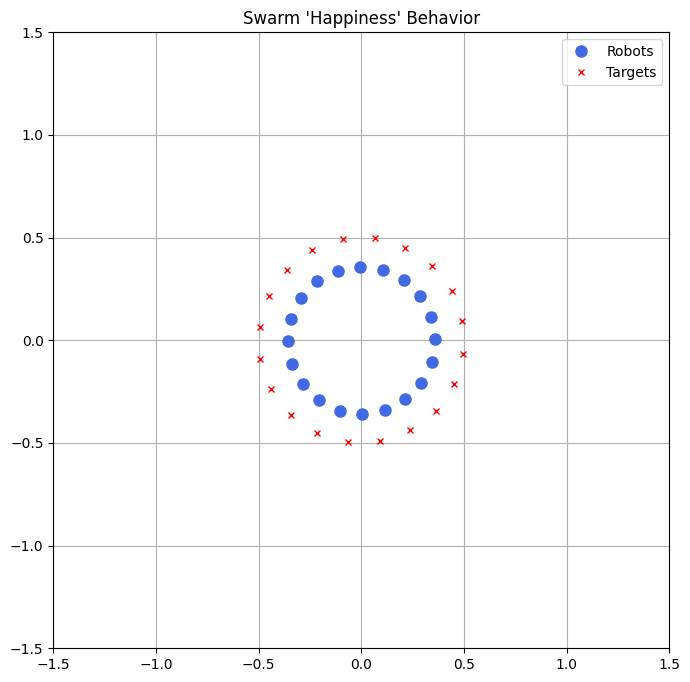

In [11]:
#animation

N_DRONE = 20


# simulated_path, target_path = happiness(N=N_DRONE, T_steps=300)

# simulated_path, target_path = surprise(N=N_DRONE, T_steps=300)

simulated_path, target_path = sadness(N=N_DRONE, T_steps=300)


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title("Swarm 'Happiness' Behavior")
ax.grid(True)

robots, = ax.plot([], [], 'o', color='royalblue', markersize=8, label="Robots")
targets, = ax.plot([], [], 'x', color='red', markersize=5, label="Targets")
ax.legend()

def update(frame):
    robots.set_data(simulated_path[frame, :, 0], simulated_path[frame, :, 1])
    targets.set_data(target_path[frame, :, 0], target_path[frame, :, 1])
    return robots, targets

ani = FuncAnimation(fig, update, frames=len(target_path), interval=200, blit=True)

print("Saving animation as GIF... This may take a moment.")
ani.save('swarm_animation.gif', writer='pillow', fps=8)